In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from tqdm import tqdm

In [2]:
from p_tqdm import p_map

In [3]:
import matplotlib.pyplot as plt

In [4]:
train_period = pd.date_range("2003-01-01", "2017-12-31")
val_period = pd.date_range("2018-01-01", "2023-12-31")
total_period = pd.date_range("2003-01-01", "2023-12-31")

In [5]:
# load cci lakes
cci_lake_list = pd.read_csv("../data/cci_lakes_hydrolake_depth.csv")["CCI ID"].to_numpy()
cci_lakes = pd.read_csv("../data/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021_4laketemp.csv", index_col=0).loc[cci_lake_list]
cci_lakes_gdf = gpd.GeoDataFrame(cci_lakes, geometry=gpd.points_from_xy(cci_lakes['LON CENTRE'], cci_lakes['LAT CENTRE']),
                                crs="epsg:4326")
cci_lakes_gdf.index.name = "cci_lake_id"

In [6]:
# load daily continous temperature
df_tw = pd.read_csv("/nas/cee-hydro/laketemp_bias/era5land/water_temp.csv", index_col=0, 
                    parse_dates=True).loc[total_period, cci_lake_list.astype(str)]

In [7]:
# data paths to simulated water temperature
a2w_full_sim_dir = "/nas/cee-hydro/laketemp_bias/simulations/a2w_full_sim"
a2w_cloud_sim_dir = "/nas/cee-hydro/laketemp_bias/simulations/a2w_cloud_sim"
lstm_full_sim_dir = "/nas/cee-hydro/laketemp_bias/simulations/lstm_full_sim"
lstm_cloud_sim_dir = "/nas/cee-hydro/laketemp_bias/simulations/lstm_cloud_sim"

In [8]:
def calc_rmse(obs, sim):
    if len(obs) != len(sim):
        raise ValueError("Arrays must have the same size.")

    mask = ~np.isnan(obs)
    obs = obs[mask]
    sim = sim[mask]
        
    # Calculate the rmse value
    rmse_val = np.sqrt(np.mean((obs-sim)**2))
    return rmse_val

In [9]:
def cal_ice_rmse(cci_lake_id):
    # filter out observation when observed tw is 0
    obs_df_tw = df_tw.loc[:, [str(cci_lake_id)]]
    obs_df_tw = obs_df_tw.loc[obs_df_tw[str(cci_lake_id)] <= 0]
    
    # set the tw as 0
    obs_df_tw[str(cci_lake_id)] = np.zeros(len(obs_df_tw))
    
    if len(obs_df_tw) == 0:
        # non ice covered lakes
        # skip
        rmse_lstm_full = np.nan
        rmse_lstm_cloud = np.nan
    else:
        # load simulated tw
        lstm_full_sim = pd.read_csv(f"{lstm_full_sim_dir}/{cci_lake_id}.csv", index_col = 0, parse_dates=True).loc[obs_df_tw.index].mean(axis = 1)
        lstm_cloud_sim = pd.read_csv(f"{lstm_cloud_sim_dir}/{cci_lake_id}.csv", index_col = 0, parse_dates=True).loc[obs_df_tw.index].mean(axis = 1)
        rmse_lstm_full = calc_rmse(obs_df_tw.values.ravel(), lstm_full_sim.values.ravel())
        rmse_lstm_cloud = calc_rmse(obs_df_tw.values.ravel(), lstm_cloud_sim.values.ravel())
        
    output_dict = {"rmse_full": rmse_lstm_full, 
                   "rmse_cloud": rmse_lstm_cloud}
    return output_dict

In [10]:
rmse_ice = pd.DataFrame(p_map(cal_ice_rmse, cci_lake_list))

  0%|          | 0/2016 [00:00<?, ?it/s]

In [11]:
import seaborn as sns

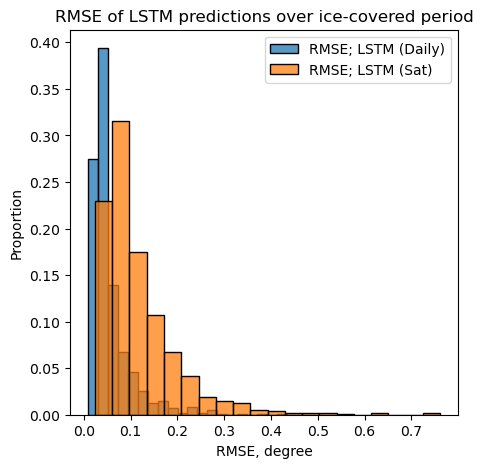

In [15]:
fig, ax = plt.subplots(figsize = (5,5))
sns.histplot(data = rmse_ice, x = "rmse_full", bins = 20, stat = "proportion", label = "RMSE; LSTM (Daily)", ax = ax)
sns.histplot(data = rmse_ice, x = "rmse_cloud", bins = 20, stat = "proportion", label = "RMSE; LSTM (Sat)", ax = ax)
ax.set_xlabel("RMSE, degree")
ax.set_title("RMSE of LSTM predictions over ice-covered period")
ax.legend()

In [16]:
fig.savefig("../figs/rmse_ice_cover.png", dpi = 300, bbox_inches='tight')

In [24]:
rmse_ice.describe()

,rmse_full,rmse_cloud
count,1323.000000,1323.000000
mean,0.054547,0.116019
std,0.044552,0.081950
min,0.008796,0.023884
25%,0.028728,0.063327
50%,0.041343,0.092010
75%,0.061859,0.143131
max,0.434476,0.761645
